In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
import PIL

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Pre Process

In [ ]:
data_dir = "archive\Garbage classification\Garbage classification"
img_height = 224
img_width = 224  


<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\jiray\AppData\Local\Temp\ipykernel_21540\3472713687.py:1: SyntaxWarning: invalid escape sequence '\G'
  data_dir = "archive\Garbage classification\Garbage classification"


In [4]:
class_count = {}
for class_name in os.listdir(data_dir):
  class_path = os.path.join(data_dir, class_name)
  if os.path.isdir(class_path):
    num_files = len(os.listdir(class_path))
    class_count[class_name] = num_files
    print(f"{class_name} {num_files}")

max_class = max(class_count.values())
print(class_count)
print(f"Max class = {max_class}")

cardboard 594
glass 594
metal 594
paper 594
plastic 594
trash 594
{'cardboard': 594, 'glass': 594, 'metal': 594, 'paper': 594, 'plastic': 594, 'trash': 594}
Max class = 594


Data Augmentation

In [5]:
class ProbabilisticLayer(tf.keras.layers.Layer):
    def __init__(self, layer, probability=0.5, **kwargs):
        super(ProbabilisticLayer, self).__init__(**kwargs)
        self.layer = layer
        self.probability = probability

    def call(self, inputs, training=None):
        # ถ้าไม่ได้อยู่ในโหมด training ให้ข้ามไปเลย
        if not training:
            return inputs
        
        # สุ่มค่าระหว่าง 0-1
        # ถ้าค่าน้อยกว่า probability ที่กำหนด ให้รัน Layer ข้างใน
        if tf.random.uniform(()) < self.probability:
            return self.layer(inputs)
        # มิฉะนั้น ให้ส่งข้อมูลเดิมกลับไป
        else:
            return inputs

In [6]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        ProbabilisticLayer(tf.keras.layers.RandomRotation(0.2), probability=0.5),
        ProbabilisticLayer(tf.keras.layers.RandomZoom(0.2), probability=0.5),
        ProbabilisticLayer(tf.keras.layers.RandomBrightness(factor=0.2), probability=0.3),
        ProbabilisticLayer(tf.keras.layers.RandomContrast(factor=0.2), probability=0.3)
    ]
)

In [7]:
import glob

for class_name, current_count in class_count.items():
    if current_count < max_class:
        num_to_generate = max_class - current_count
        
        class_path = os.path.join(data_dir, class_name)
        # print(class_path)
        search_pattern = os.path.join(class_path, "*.jpg")
        image_paths = glob.glob(search_pattern)
        # print(image_paths)

        for i in range(num_to_generate):
            random_image_path = np.random.choice(image_paths)
            img = tf.keras.utils.load_img(random_image_path)
            img_array = tf.keras.utils.img_to_array(img)
            # print(img_array.shape)
            img_tensor = tf.expand_dims(img_array, 0) #แปลงเป็น batch โดย batch_size = 1
            # print(img_tensor)
            # break
            augmented_tensor = data_augmentation(img_tensor)
            augmented_image = tf.keras.utils.array_to_img(augmented_tensor[0]) #แปลง tensor to img ได้เหมือนกัน


            original_filename = os.path.basename(random_image_path) #เอามาแต่ข้างหลังสุด
            filename_without_ext = os.path.splitext(original_filename)[0]
            new_filename = f"{filename_without_ext}_aug_{i}.jpg"
            full_path_to_save = os.path.join(class_path, new_filename)
            augmented_image.save(full_path_to_save)

In [8]:
class_count = {}
for class_name in os.listdir(data_dir):
  class_path = os.path.join(data_dir, class_name)
  if os.path.isdir(class_path):
    num_files = len(os.listdir(class_path))
    class_count[class_name] = num_files
    print(f"{class_name} {num_files}")

max_class = max(class_count.values())
print(class_count)
print(f"Max class = {max_class}")

cardboard 594
glass 594
metal 594
paper 594
plastic 594
trash 594
{'cardboard': 594, 'glass': 594, 'metal': 594, 'paper': 594, 'plastic': 594, 'trash': 594}
Max class = 594


In [9]:
# files_to_delete = []

# search_pattern = os.path.join(data_dir, '**', '*_aug_*.jpg')
# files_to_delete = glob.glob(search_pattern, recursive=True)

# print(f"--- พบไฟล์ที่จะลบทั้งหมด {len(files_to_delete)} ไฟล์ ---")
# for file_path in files_to_delete:
#     print(file_path)
# print("---------------------------------------------")


# confirmation = input("คุณต้องการลบไฟล์เหล่านี้ทั้งหมดใช่หรือไม่? (y/n): ")
# for file_path in files_to_delete:
#     os.remove(file_path) # คำสั่งลบไฟล์ของ os
# print(f"ลบไฟล์ทั้งหมด {len(files_to_delete)} ไฟล์เรียบร้อยแล้ว")

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,                  
  subset="training",                      
  seed=2222,                              
  image_size=(img_height, img_width),   
  batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",                
  seed=123,
  image_size=(img_height, img_width), 
  batch_size=32
)

Found 3564 files belonging to 6 classes.
Using 2852 files for training.
Found 3564 files belonging to 6 classes.
Using 712 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)
print(f"class numbers {len(class_names)}")

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
class numbers 6


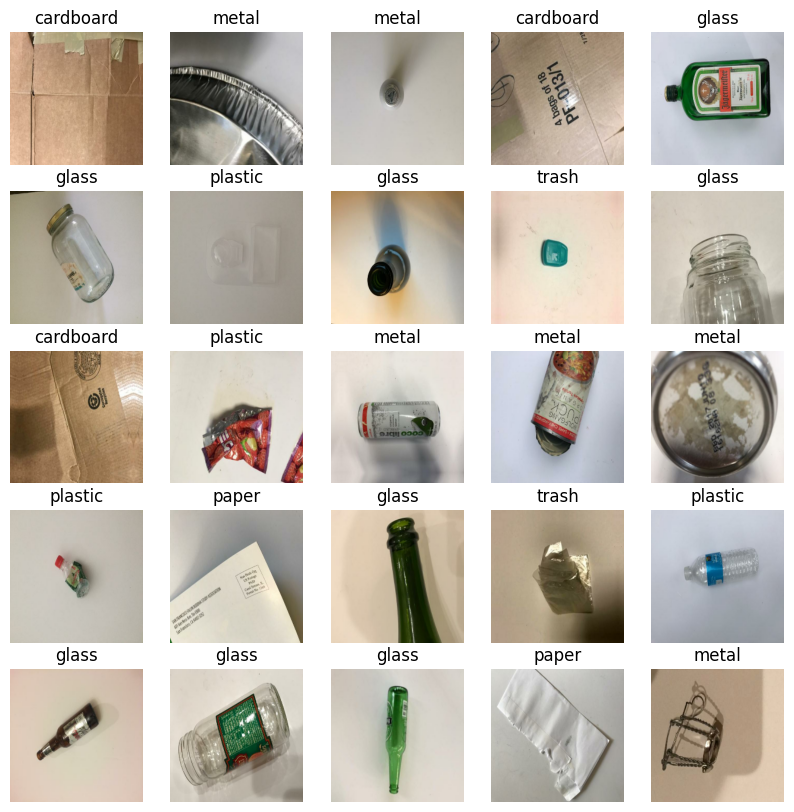

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(32, 224, 224, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = len(class_names)

model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255.0, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes)
])

model.summary()

c:\Users\jiray\OneDrive\Documents\Linear_project\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,235,270 (50.49 MB)

 Trainable params: 13,235,270 (50.49 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras',                  
                                               monitor='val_loss', mode='min',
                                               save_best_only=True,
                                               verbose=1,)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) 

In [18]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  callbacks=[callback, early_stopping]
)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.2382 - loss: 1.7969
Epoch 1: val_loss improved from None to 1.41836, saving model to best_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 94s 949ms/step - accuracy: 0.3110 - loss: 1.6371 - val_accuracy: 0.4466 - val_loss: 1.4184
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.4374 - loss: 1.4662
Epoch 2: val_loss improved from 1.41836 to 1.37057, saving model to best_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 557ms/step - accuracy: 0.4509 - loss: 1.4221 - val_accuracy: 0.5000 - val_loss: 1.3706
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.4967 - loss: 1.3164
Epoch 3: val_loss improved from 1.37057 to 1.24618, saving model to best_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 537ms/step - accuracy: 0.5168 - loss: 1.2819 - val_accuracy: 0.5365 - val_loss: 1.2462
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.5629 - loss: 1.1710
Epoch 4: val_loss improved from 1.24618 to 1.0

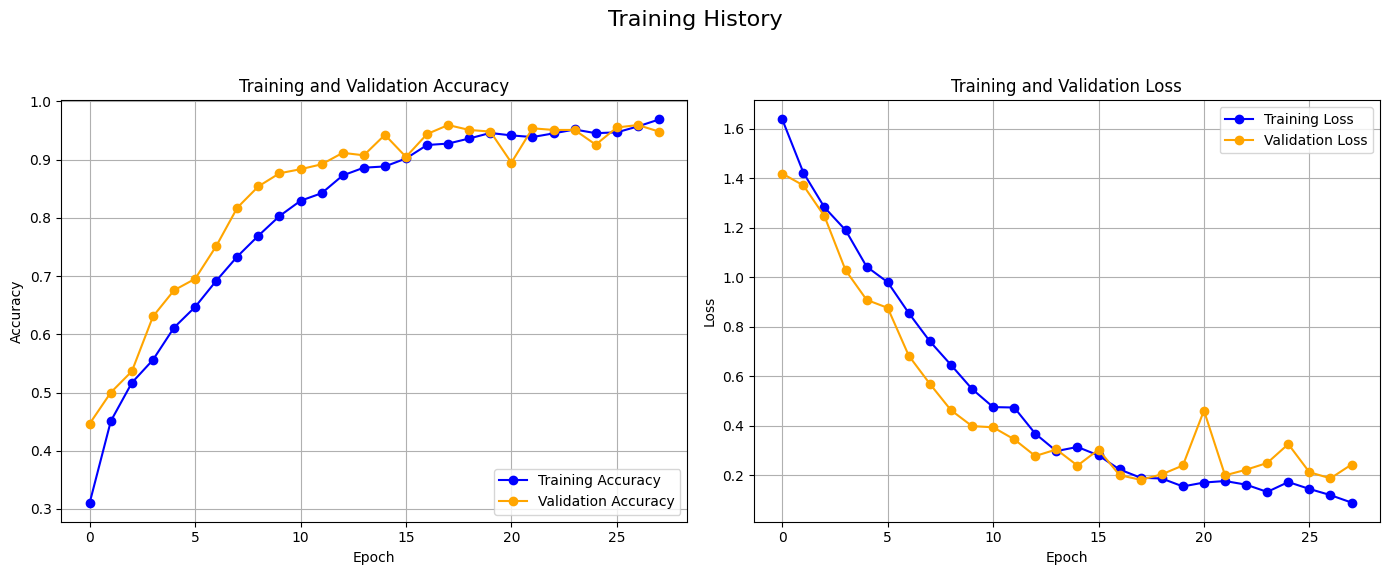

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# สร้างช่วงของแกน X (จำนวน epochs)
epochs_range = range(len(acc))

# --- สร้างกราฟ ---
plt.figure(figsize=(14, 6)) # กำหนดขนาดของพื้นที่วาดทั้งหมด

# กราฟที่ 1: Training and Validation Accuracy
plt.subplot(1, 2, 1) # สร้าง subplot ที่ 1 (จากทั้งหมด 1 แถว 2 คอลัมน์)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True) # เพิ่มเส้นกริด

# กราฟที่ 2: Training and Validation Loss
plt.subplot(1, 2, 2) # สร้าง subplot ที่ 2
plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True) # เพิ่มเส้นกริด

# แสดงกราฟทั้งหมด
plt.suptitle('Training History', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # ปรับ layout ให้สวยงาม
plt.show()

In [23]:

loss, accuracy = model.evaluate(val_ds)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9593 - loss: 0.1809
Test Loss: 0.1809
Test Accuracy: 95.93%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


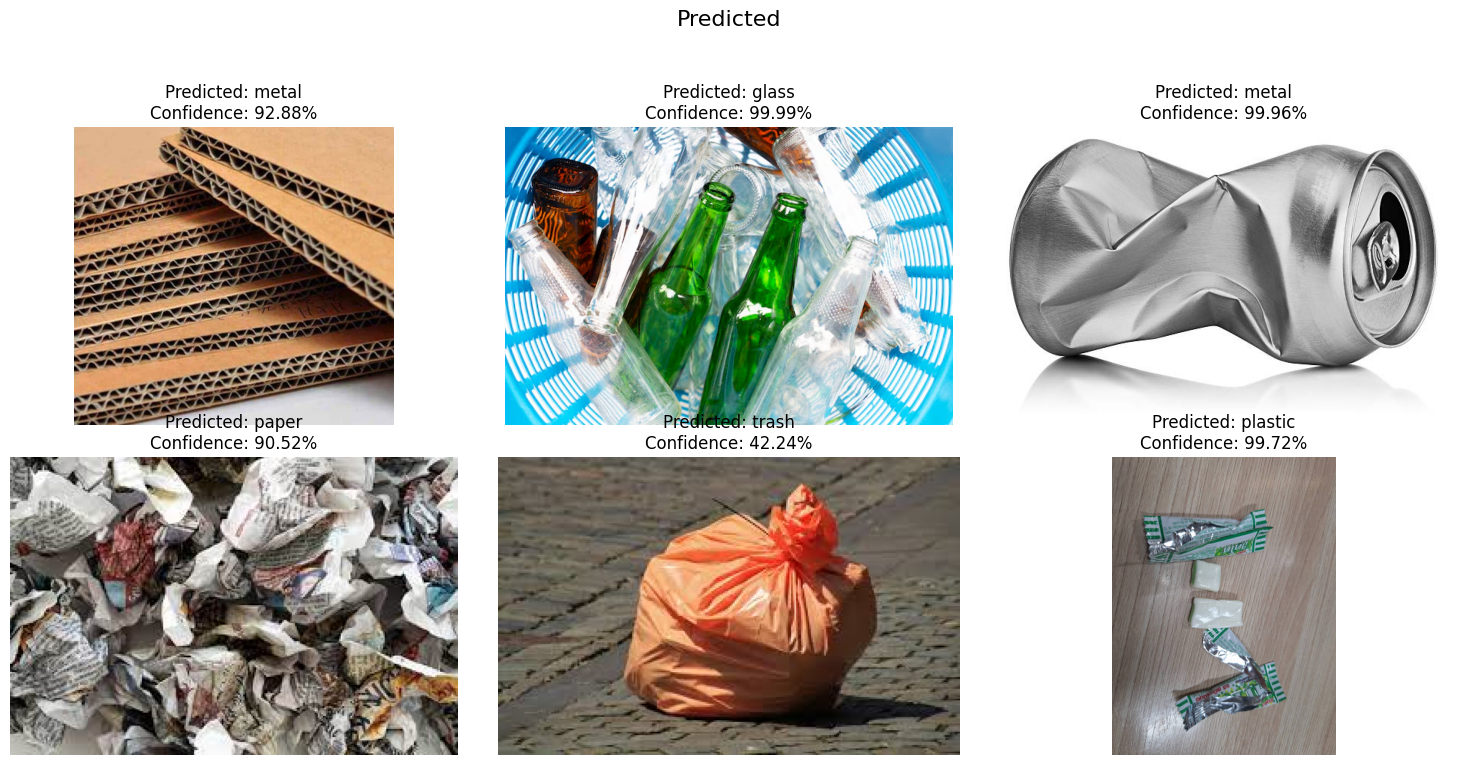

In [26]:
best_model = tf.keras.models.load_model('ืmodel_95_93_loss_0.1809.keras')

test_folder = 'test_image/'
image_paths = [os.path.join(test_folder, fname) for fname in os.listdir(test_folder) if fname.endswith('.jpg')]

batch_holder = []
for path in image_paths:
    img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    batch_holder.append(img_array)

image_batch = np.array(batch_holder)

predictions = best_model.predict(image_batch)
scores = tf.nn.softmax(predictions)

plt.figure(figsize=(15, 8)) 
plt.suptitle("Predicted", fontsize=16)

for i in range(len(image_paths)):
    ax = plt.subplot(2, 3, i + 1)
    img_display = tf.keras.utils.load_img(image_paths[i])
    
    predicted_class = class_names[np.argmax(scores[i])]
    confidence = 100 * np.max(scores[i])

    plt.imshow(img_display)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()